## Background

In this blog post, I demonstrate how I achieved 94.8% accuracy in classifying sentiment in the `financial_phrasebank` dataset using Claude-3.5-Sonnet, 94.1% accuracy using Claude-3-Opus, and 92.4% accuracy using Haiku, all accessed through the Answer.AI library `claudette`.

This notebook is part of [a series of blog posts](https://vishalbakshi.github.io/blog/#category=TinySentiment) for a project I'm working called **TinySentiment** where I'm experimenting with tiny models to improve their ability to classify sentiment in the `financial_phrasebank` dataset. This notebook establishes a baseline using these larger models.

Here is a summary of results from this notebook. The best performing approach (3-Shot prompt with Sonnet) cost \$2.27, while it cost \$3.50 for Zero-Shot Opus:

|Model|Prompt|Overall Accuracy|`negative`|`neutral`|`positive`|
|:-:|:-:|:-:|:-:|:-:|:-:|
|claude-3-5-sonnet-20240620|3-Shot|94.78%|98% (297/303)|94% (1302/1391)|95% (544/570)|
|claude-3-opus-20240229|Zero-Shot|94.13%|98% (297/303)|96% (1333/1391)|88% (501/570)|
|claude-3-5-sonnet-20240620|Zero-Shot|94%|98% (297/303)|92% (1279/1391)|97% (552/570)|
|claude-3-haiku-20240307|3-Shot|92.39%|90% (272/303)|91% (1267/1391)|96% (550/570)|
|claude-3-haiku-20240307|Zero-Shot|89.84%|96% (292/303)|85% (1183/1391)|98% (559/570)|
|claude-3-haiku-20240307|6-Shot|84.99%|98% (296/303)|76% (1059/1391)|99% (564/570)|

## Setup

In [ ]:
#| code-fold: true
#| code-summary: "Show imports and setup"
!pip install datasets -Uqq
!pip install claudette -qq
from datasets import load_dataset, Dataset
from transformers.pipelines.pt_utils import KeyDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from claudette import *

dataset = load_dataset(
    "financial_phrasebank", "sentences_allagree",
    split="train"  # note that the dataset does not have a default test split
)

In [2]:
#| code-fold: true
#| code-summary: "Show imports"
!pip install claudette -qq
from claudette import *

In [4]:
#| code-fold: true
#| code-summary: "Show function to make confusion matrix"
def make_cm(df):
    """Create confusion matrix for true vs predicted sentiment classes"""

    cm = confusion_matrix(y_true=df['label_text'], y_pred=df['responses'], labels=['negative', 'neutral', 'positive'])
    disp = ConfusionMatrixDisplay(cm, display_labels=['negative', 'neutral', 'positive'])

    fig, ax = plt.subplots(figsize=(4,4))
    disp.plot(ax=ax,text_kw={'fontsize': 12}, cmap='Blues', colorbar=False);

    # change label font size without changing label text
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)

    # make tick labels larger
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

## Performing Sentiment Classification with Claude

### 3-Opus

Since Opus is pricier, I'll only do sentiment classification once.

I'll start by asking Claude (through the UI on claude.ai) for a recommended prompt for this task:

> Classify the sentiment of this financial news sentence as either negative, neutral, or positive. Respond with ONLY the sentiment label, no other text:
>
>[Insert sentence here]

In [13]:
prompt = """Classify the sentiment of this financial news sentence as either negative, neutral, or positive. Respond with ONLY the sentiment label, no other text:

{sentence}"""

In [14]:
formatted_prompt = prompt.format(sentence=dataset['sentence'][0])

In [15]:
print(formatted_prompt)

Classify the sentiment of this financial news sentence as either negative, neutral, or positive. Respond with ONLY the sentiment label, no other text:

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


In [10]:
model = models[0]
model

'claude-3-opus-20240229'

In [11]:
chat = Chat(model, sp="""You are a helpful and concise assistant.""")
chat.use

In: 0; Out: 0; Total: 0

Testing it out on a single sentence, it looks like I'm getting the correct result (a single word response).

In [16]:
r = chat(formatted_prompt)
r

neutral

<details>

- id: `msg_01UGxLBjREK1n6rap8vqokJc`
- content: `[{'text': 'neutral', 'type': 'text'}]`
- model: `claude-3-opus-20240229`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 73, 'output_tokens': 4, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0}`

</details>

Before I do the full 2264 rows, I'll test out the performance on 25 rows which should take about 5 minutes:

In [ ]:
results = []
tokens = 0

for row in dataset.select(range(25)):
  chat = Chat(model, sp="""You are a helpful and concise assistant.""")
  formatted_prompt = prompt.format(sentence=row['sentence'])
  r = chat(formatted_prompt)
  results.append(r.content[0].text)
  tokens += chat.use.total

In [33]:
tokens

2561

Looking at the responses, the model is consistently (correctly) responding with a single-word label.

In [24]:
results

['neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive']

In [38]:
results = []
tokens = 0

for row in dataset:
  chat = Chat(model, sp="""You are a helpful and concise assistant.""")
  formatted_prompt = prompt.format(sentence=row['sentence'])
  r = chat(formatted_prompt)
  results.append(r.content[0].text)
  tokens += chat.use.total

In [42]:
tokens, len(results)

(191874, 2264)

In [45]:
model

'claude-3-opus-20240229'

In [66]:
df = dataset.to_pandas()
df['label_text'] = df['label'].apply(lambda x: dataset.features['label'].names[x])
df['responses'] = results
df['match'] = df['label_text'] == df['responses']
df.head()

,sentence,label,label_text,responses,match
0,"According to Gran , the company has no plans t...",1,neutral,neutral,True
1,"For the last quarter of 2010 , Componenta 's n...",2,positive,positive,True
2,"In the third quarter of 2010 , net sales incre...",2,positive,positive,True
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,positive,positive,True
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,positive,positive,True


Claude-3 Opus achieves a **94% accuracy**, which matches the GPT4 accuracy in the [original blog post](https://huggingface.co/blog/synthetic-data-save-costs) by Moritz Laurer that motivated my **TinySentiment** project.

In [67]:
df['match'].mean()

0.9412544169611308

Opus classifies `neutral` with the highest true positive rate (1333/1391---note that two of the `neutral` responses were neither `positive` nor `negative`), followed by `negative` (297/303) and `positive` (501/570) sentences.

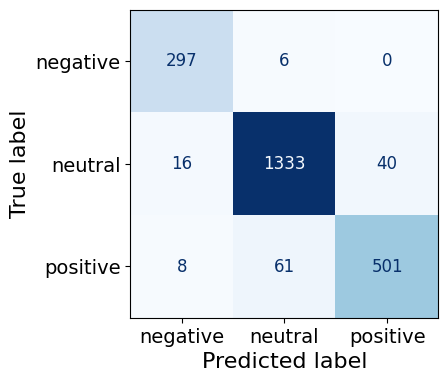

In [57]:
make_cm(df)

### 3.5-Sonnet

In [68]:
model = models[1]
model

'claude-3-5-sonnet-20240620'

In [70]:
print(prompt)

Classify the sentiment of this financial news sentence as either negative, neutral, or positive. Respond with ONLY the sentiment label, no other text:

{sentence}


In [71]:
results = []
tokens = 0

for row in dataset:
  chat = Chat(model, sp="""You are a helpful and concise assistant.""")
  formatted_prompt = prompt.format(sentence=row['sentence'])
  r = chat(formatted_prompt)
  results.append(r.content[0].text)
  tokens += chat.use.total

In [73]:
tokens, len(results)

(194516, 2264)

What I immediately notice about the results is that Sonnet capitalized the first letter of the response in some cases:

In [74]:
results[0]

'Neutral'

In [77]:
df = dataset.to_pandas()
df['label_text'] = df['label'].apply(lambda x: dataset.features['label'].names[x])
df['responses'] = results
df['responses'] = df['responses'].apply(lambda x: x.lower())
df['match'] = df['label_text'] == df['responses']
df.head()

,sentence,label,label_text,responses,match
0,"According to Gran , the company has no plans t...",1,neutral,neutral,True
1,"For the last quarter of 2010 , Componenta 's n...",2,positive,positive,True
2,"In the third quarter of 2010 , net sales incre...",2,positive,positive,True
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,positive,positive,True
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,positive,positive,True


Sonnet gets about the same accuracy, **94%**, as Opus and GPT4! Opus cost me \$3.50 while Sonnet cost me \$0.73.

In [78]:
df['match'].mean()

0.9399293286219081

Sonnet outshines Opus in correctly predicting `positive` sentiment (552 to 501) matches it for `negative` sentences (297 each) and does a bit worse for `neutral` sentences (1279 to 1333).

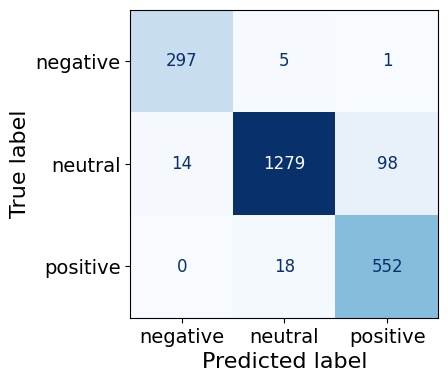

In [79]:
make_cm(df)

### 3-Haiku

I expect Haiku to perform worse, but then again I might get surprised!

In [83]:
model = models[2]
model

'claude-3-haiku-20240307'

In [84]:
print(prompt)

Classify the sentiment of this financial news sentence as either negative, neutral, or positive. Respond with ONLY the sentiment label, no other text:

{sentence}


In [85]:
results = []
tokens = 0

for row in dataset:
  chat = Chat(model, sp="""You are a helpful and concise assistant.""")
  formatted_prompt = prompt.format(sentence=row['sentence'])
  r = chat(formatted_prompt)
  results.append(r.content[0].text)
  tokens += chat.use.total

In [86]:
tokens, len(results)

(193756, 2264)

In [88]:
df = dataset.to_pandas()
df['label_text'] = df['label'].apply(lambda x: dataset.features['label'].names[x])
df['responses'] = results
df['responses'] = df['responses'].apply(lambda x: x.lower())
df['match'] = df['label_text'] == df['responses']
df.head()

,sentence,label,label_text,responses,match
0,"According to Gran , the company has no plans t...",1,neutral,neutral,True
1,"For the last quarter of 2010 , Componenta 's n...",2,positive,positive,True
2,"In the third quarter of 2010 , net sales incre...",2,positive,positive,True
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,positive,positive,True
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,positive,positive,True


Haiku doesn't perform as well, but it's not too shabby at **90% accuracy**.

In [89]:
df['match'].mean()

0.8984098939929329

Haiku actually beats both Opus _and_ Sonnet in predicting `positive` sentences correctly (559 vs. 552 and 501), and is competitive in the `negative` true positive rate (292 vs 297). Where it lacks is in predicting `neutral` sentences (1183 vs. 1279 and 1333).

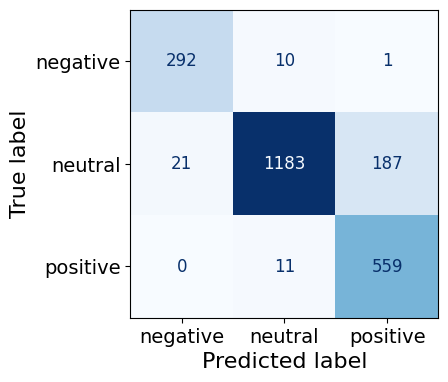

In [90]:
make_cm(df)

## Prompt Engineering with Haiku

Since Haiku is the cheapest model, I'll try different prompts and see if it improves its performance.

### Prompt B

I'll create a few-shot prompt and exclude the three examples used in the prompt from the dataset.


In [5]:
exclude_idxs = [0, 1, 292]

In [6]:
def ds_subset(dataset, exclude_idxs):
    idxs = list(range(len(dataset)))
    idxs = [x for x in idxs if x not in exclude_idxs]
    ddf = dataset.to_pandas()
    new_ds = Dataset.from_pandas(ddf.iloc[idxs])
    return new_ds

In [7]:
promptB_ds = ds_subset(dataset, exclude_idxs)
promptB_ds

Dataset({
    features: ['sentence', 'label', '__index_level_0__'],
    num_rows: 2261
})

In [16]:
for example in dataset.select([0, 1, 292]):
  print(example)

{'sentence': 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .', 'label': 1}
{'sentence': "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .", 'label': 2}
{'sentence': 'Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .', 'label': 0}


In [8]:
promptB = """Classify the sentiment of this financial news sentence as either negative, neutral, or positive. Respond with ONLY the sentiment label, no other text:

Examples:

sentence: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with ONLY the sentiment label, no other text.
sentiment: neutral

sentence: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with ONLY the sentiment label, no other text.
sentiment: positive

sentence: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with ONLY the sentiment label, no other text.
sentiment: negative

sentence: {sentence}
Respond with ONLY the sentiment label, no other text.
sentiment: """

In [19]:
formatted_prompt = promptB.format(sentence=promptB_ds['sentence'][0])
print(formatted_prompt)

Classify the sentiment of this financial news sentence as either negative, neutral, or positive. Respond with ONLY the sentiment label, no other text:

Examples:

sentence: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with ONLY the sentiment label, no other text.
sentiment: neutral

sentence: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with ONLY the sentiment label, no other text.
sentiment: positive

sentence: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with ONLY the sentiment label, no other text.
sentiment: negative

sentence: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .
Respo

In [13]:
model = models[2]
model

'claude-3-haiku-20240307'

In [20]:
chat = Chat(model, sp="""You are a helpful and concise assistant.""")
chat(formatted_prompt)

positive

<details>

- id: `msg_0194ehQYJKJ7u5SJVQRXGFSx`
- content: `[{'text': 'positive', 'type': 'text'}]`
- model: `claude-3-haiku-20240307`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'input_tokens': 299, 'output_tokens': 4, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0}`

</details>

In [21]:
promptB_ds['label'][0]

2

I'll do a test run through 25 rows which should take less than a minute:

In [ ]:
results = []
tokens = 0

for row in promptB_ds.select(range(25)):
  chat = Chat(model, sp="""You are a helpful and concise assistant.""")
  formatted_prompt = promptB.format(sentence=row['sentence'])
  print(formatted_prompt)
  r = chat(formatted_prompt)
  results.append(r.content[0].text)
  tokens += chat.use.total

The results, at least in terms of formatting, look good.

In [23]:
results

['positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive']

The results are also correct (all 25 are `positive` sentences):

In [24]:
promptB_ds.select(range(25))['label']

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [25]:
tokens

7655

In [26]:
results = []
tokens = 0

for row in promptB_ds:
  chat = Chat(model, sp="""You are a helpful and concise assistant.""")
  formatted_prompt = promptB.format(sentence=row['sentence'])

  r = chat(formatted_prompt)
  results.append(r.content[0].text)
  tokens += chat.use.total

In [27]:
tokens, len(results)

(650542, 2261)

In [29]:
df = promptB_ds.to_pandas()
df['label_text'] = df['label'].apply(lambda x: dataset.features['label'].names[x])
df['responses'] = results
df['responses'] = df['responses'].apply(lambda x: x.lower())
df['match'] = df['label_text'] == df['responses']
df.head()

,sentence,label,__index_level_0__,label_text,responses,match
0,"In the third quarter of 2010 , net sales incre...",2,2,positive,positive,True
1,Operating profit rose to EUR 13.1 mn from EUR ...,2,3,positive,positive,True
2,"Operating profit totalled EUR 21.1 mn , up fro...",2,4,positive,positive,True
3,Finnish Talentum reports its operating profit ...,2,5,positive,positive,True
4,Clothing retail chain Sepp+ñl+ñ 's sales incre...,2,6,positive,positive,True


With 3-shot prompting, Haiku achieves 92.4% accuracy. Not bad!

In [30]:
df['match'].mean()

0.9239274657231313

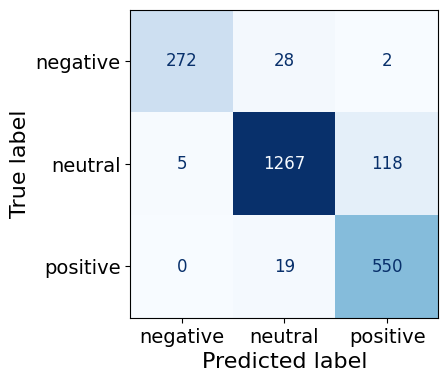

In [31]:
make_cm(df)

## Sonnet: 3-Shot Prompt

Given the success of 3-shot prompting with Haiku, I'll spend a couple of dollars and use that prompt for Sonnet:

In [10]:
model = models[1]
model

'claude-3-5-sonnet-20240620'

In [11]:
print(promptB)

Classify the sentiment of this financial news sentence as either negative, neutral, or positive. Respond with ONLY the sentiment label, no other text:

Examples:

sentence: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with ONLY the sentiment label, no other text.
sentiment: neutral

sentence: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with ONLY the sentiment label, no other text.
sentiment: positive

sentence: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with ONLY the sentiment label, no other text.
sentiment: negative

sentence: {sentence}
Respond with ONLY the sentiment label, no other text.
sentiment: 


Testing out with 10 rows of data:

In [34]:
results = []
tokens = 0

for row in promptB_ds.select(range(10)):
  chat = Chat(model, sp="""You are a helpful and concise assistant.""")
  formatted_prompt = promptB.format(sentence=row['sentence'])

  r = chat(formatted_prompt)
  results.append(r.content[0].text)
  tokens += chat.use.total

The outputs look good!

In [35]:
results

['positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive']

Running inference on the full dataset:

In [12]:
model == 'claude-3-5-sonnet-20240620'

True

In [ ]:
results = []
tokens = 0

In [60]:
idxs = [idx for idx in range(len(promptB_ds)) if idx > 2212]
idxs[0], idxs[-1], len(idxs)

(2213, 2260, 48)

In [61]:
for row in promptB_ds.select(idxs):
  chat = Chat(model, sp="""You are a helpful and concise assistant.""")
  formatted_prompt = promptB.format(sentence=row['sentence'])

  r = chat(formatted_prompt)
  results.append(r.content[0].text)
  tokens += chat.use.total

In [62]:
tokens, len(results)

(650584, 2261)

In [64]:
df = promptB_ds.to_pandas()
df['label_text'] = df['label'].apply(lambda x: dataset.features['label'].names[x])
df['responses'] = results
df['responses'] = df['responses'].apply(lambda x: x.lower())
df['match'] = df['label_text'] == df['responses']
df.head()

,sentence,label,__index_level_0__,label_text,responses,match
0,"In the third quarter of 2010 , net sales incre...",2,2,positive,positive,True
1,Operating profit rose to EUR 13.1 mn from EUR ...,2,3,positive,positive,True
2,"Operating profit totalled EUR 21.1 mn , up fro...",2,4,positive,positive,True
3,Finnish Talentum reports its operating profit ...,2,5,positive,positive,True
4,Clothing retail chain Sepp+ñl+ñ 's sales incre...,2,6,positive,positive,True


With 3-shot prompting, Sonnet-3.5 beats the 0-shot Opus result by 0.65%

In [67]:
df['match'].mean()

0.9478107032286599

Compared to 0-shot prompting, the 3-shot prompt for Sonnet had the same number of true positives for `negative` sentences (297), 23 more for `neutral` sentences (1302 vs. 1279) and 8 fewer for `positive` sentences (544 vs. 552).

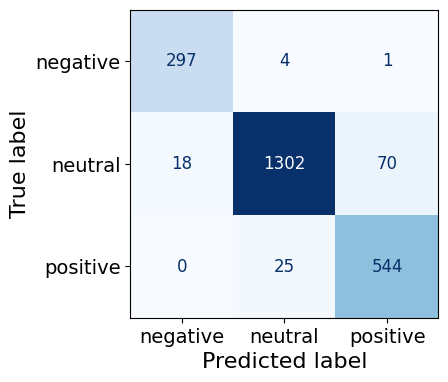

In [68]:
make_cm(df)

## 6-shot Haiku

As a final experiment, I'll double the number of examples provided in the prompt to 6 and see if that improves Haiku's performance.

In [69]:
promptC = """Classify the sentiment of this financial news sentence as either negative, neutral, or positive. Respond with ONLY the sentiment label, no other text:

Examples:

sentence: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with ONLY the sentiment label, no other text.
sentiment: neutral

sentence: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with ONLY the sentiment label, no other text.
sentiment: positive

sentence: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with ONLY the sentiment label, no other text.
sentiment: negative

sentence: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .
Respond with ONLY the sentiment label, no other text.
sentiment: neutral

sentence: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCREASE IN SHARE CAPITAL A total of 119 850 shares have been subscribed with BasWare Warrant Program .
Respond with ONLY the sentiment label, no other text.
sentiment: neutral

sentence: A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004 stock option plan .
Respond with ONLY the sentiment label, no other text.
sentiment: neutral

sentence: {sentence}
Respond with ONLY the sentiment label, no other text.
sentiment: """

In [74]:
formatted_prompt = promptC.format(sentence=dataset[10]['sentence'])
print(formatted_prompt)

Classify the sentiment of this financial news sentence as either negative, neutral, or positive. Respond with ONLY the sentiment label, no other text:

Examples:

sentence: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with ONLY the sentiment label, no other text.
sentiment: neutral

sentence: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with ONLY the sentiment label, no other text.
sentiment: positive

sentence: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with ONLY the sentiment label, no other text.
sentiment: negative

sentence: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research 

In [71]:
exclude_idxs = [0, 1, 292, 37, 38, 39]
promptC_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptC_ds

Dataset({
    features: ['sentence', 'label', '__index_level_0__'],
    num_rows: 2258
})

In [76]:
results = []
tokens = 0

In [98]:
idxs = [idx for idx in range(len(promptC_ds)) if idx > (len(results) - 1)]
idxs[0], idxs[-1], len(idxs)

(1974, 2257, 284)

In [93]:
model = models[2]
model == 'claude-3-haiku-20240307'

True

In [99]:
for row in promptC_ds.select(idxs):
  chat = Chat(model, sp="""You are a helpful and concise assistant.""")
  formatted_prompt = promptC.format(sentence=row['sentence'])
  r = chat(formatted_prompt)
  results.append(r.content[0].text)
  tokens += chat.use.total

In [100]:
tokens, len(results)

(1144141, 2258)

In [101]:
df = promptC_ds.to_pandas()
df['label_text'] = df['label'].apply(lambda x: dataset.features['label'].names[x])
df['responses'] = results
df['responses'] = df['responses'].apply(lambda x: x.lower())
df['match'] = df['label_text'] == df['responses']
df.head()

,sentence,label,__index_level_0__,label_text,responses,match
0,"In the third quarter of 2010 , net sales incre...",2,2,positive,positive,True
1,Operating profit rose to EUR 13.1 mn from EUR ...,2,3,positive,positive,True
2,"Operating profit totalled EUR 21.1 mn , up fro...",2,4,positive,positive,True
3,Finnish Talentum reports its operating profit ...,2,5,positive,positive,True
4,Clothing retail chain Sepp+ñl+ñ 's sales incre...,2,6,positive,positive,True


6-shot prompting actually worsened Haiku's performance from 92.4% (3-shot) to 85%.

In [103]:
df['match'].mean()

0.849867139061116

Interesting that Haiku performed better on `negative` sentences (296 vs. 272) and `positive` sentences (564 vs. 550) but much worse on `neutral` sentences (1059 vs. 1267) even though there were 4 `neutral` examples in the prompt.

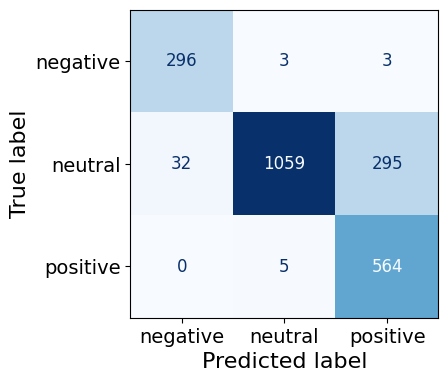

In [104]:
make_cm(df)

## Final Thoughts

Here is a summary of results from this notebook. The best performing approach (3-Shot prompt with Sonnet) cost \$2.27, cheaper than the \$3.50 for Zero-Shot Opus:

|Model|Prompt|Overall Accuracy|`negative`|`neutral`|`positive`|
|:-:|:-:|:-:|:-:|:-:|:-:|
|claude-3-5-sonnet-20240620|3-Shot|94.78%|98% (297/303)|94% (1302/1391)|95% (544/570)|
|claude-3-opus-20240229|Zero-Shot|94.13%|98% (297/303)|96% (1333/1391)|88% (501/570)|
|claude-3-5-sonnet-20240620|Zero-Shot|94%|98% (297/303)|92% (1279/1391)|97% (552/570)|
|claude-3-haiku-20240307|3-Shot|92.39%|90% (272/303)|91% (1267/1391)|96% (550/570)|
|claude-3-haiku-20240307|Zero-Shot|89.84%|96% (292/303)|85% (1183/1391)|98% (559/570)|
|claude-3-haiku-20240307|6-Shot|84.99%|98% (296/303)|76% (1059/1391)|99% (564/570)|


Here are my takeaways:

- **Opus is pricey**: I wasn't planning on experimenting with all three models. In fact, I accidentally selected Opus for the first experiment instead of Sonnet. What gave it away? How much it cost! Someone on Twitter replied to my post about this saying that inference for a multi-turn conversation was costing them $1 per turn. I believe it.
- **1 Million tokens is not that much**: I entered this experiment thinking that I'd sit well below the daily 1M token limit. I was wrong! This experiment ended up taking over 3.3M tokens (3,291,956 input / 71,075 output).
- **Haiku is competent**: For about 10% of the cost, 3-Shot Haiku was only 2.4% less accurate than the best-performing 3-Shot Sonnet. I totally understand now why folks talk about using Haiku for simpler tasks. It's so much cheaper!

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).